## Extracting patterns on daily user behaviour

We are going to play with the following dataset

1.- **Dataset name to request access:** Insights-FactLayer-Leads

2.- **Athena (SQLaaS):** {provider}_databox.insights_sessions_fact_layer_1d

3.- **S3 path** schibsted-spt-common-prod/yellow/pulse-simple/version=1-alpha/*/client=${provider}


[Athena Query](https://docs.aws.amazon.com/athena/latest/ug/functions-operators-reference-section.html) 


In [1]:
# Needed packages
from pyathena import connect
import pandas as pd
import os
import matplotlib.pyplot as plt

In [2]:
user = "maria.pelaez@schibsted.com"
provider ='yapocl'

In [3]:
from getpass import getpass
access_key = getpass(prompt="Enter your access key to databox: ")
secret_key = getpass(prompt="Enter your secret to databox: ")

# Some parameters (another different way to extract the credential)


# Doing the connection
conn = connect(aws_access_key_id=access_key,
               aws_secret_access_key=secret_key,
               s3_staging_dir="s3://schibsted-spt-common-dev/user-areas/"+ user,
               region_name="eu-west-1")

Enter your access key to databox: ········
Enter your secret to databox: ········


## Step 0: What information is available in this dataset?

In [4]:
describe_events = """
SELECT * FROM {}_databox.yellow_pulse_simple_1d LIMIT 1;
"""
pd.read_sql(describe_events.format(provider), conn).dtypes

category               object
name                   object
objectlatitude         object
objectlongitude        object
objectid               object
url                    object
items                  object
objecttype             object
useragent              object
providerid             object
providerurl            object
providerproduct        object
providerproducttype    object
environmentid          object
isloggedin               bool
jweids                 object
screensize             object
pageviewid             object
sptpageviewid          object
id                     object
type                   object
latitude               object
longitude              object
locationaccuracy       object
locationtimestamp      object
originurl              object
published              object
trackertype            object
intent                 object
objectintent           object
devicetype             object
version                object
year                    int64
month     

In [6]:
# Doing a simple query of the events in one hour
query_events = """
SELECT
  category,
  name,
  objectid,
  objecttype,
  type,
  environmentid,
  devicetype,
  providerproducttype,
  isloggedin,
  "hour"
FROM
  {}_databox.yellow_pulse_simple_1d
WHERE 
 "hour" = 20
LIMIT 2000
"""
df_events = pd.read_sql(query_events.format(provider), conn)

In [7]:
df_events.dtypes

category               object
name                   object
objectid               object
objecttype             object
type                   object
environmentid          object
devicetype             object
providerproducttype    object
isloggedin               bool
hour                    int64
dtype: object

## What are we going to learn about Python?

We are mainly going to work with the following packages:
    
1. [pandas](https://pandas.pydata.org/pandas-docs/stable/) 

This is a package providing fast, flexible, and expressive data structures designed to make working with “relational” or “labeled” 
data both easy and intuitive. 
It aims to be the fundamental high-level building block for doing practical, 
real world data analysis in Python. Additionally, it has the broader goal of becoming the most 
powerful and flexible open source data analysis / manipulation tool available in any language. 
It is already well on its way towards this goal.

[cheat sheet pandas](http://datacamp-community.s3.amazonaws.com/9f0f2ae1-8bd8-4302-a67b-e17f3059d9e8)


2. [numpy](http://www.numpy.org/)

NumPy is the fundamental package for scientific computing with Python. It contains among other things:

- a powerful N-dimensional array object

- sophisticated (broadcasting) functions

- tools for integrating C/C++ and Fortran code useful linear algebra, Fourier transform, and random number capabilities

[cheat sheet numpy](http://datacamp-community.s3.amazonaws.com/e9f83f72-a81b-42c7-af44-4e35b48b20b7)


3. [matplotlib](https://matplotlib.org/)

Matplotlib is a Python 2D plotting library which produces publication quality figures in a variety of hardcopy formats and interactive environments across platforms. Matplotlib can be used in Python scripts, the Python and IPython shells, the Jupyter notebook, web application servers, and four graphical user interface toolkits.

[cheat sheet matplotlib](http://datacamp-community.s3.amazonaws.com/28b8210c-60cc-4f13-b0b4-5b4f2ad4790b)


### Exploration of our DataFrame

*head(),tail(),shape(),columns, describe(),dtypes()*

*selection one row, one column, a subdataframe*

In [8]:
df_events.head(2)

,category,name,objectid,objecttype,type,environmentid,devicetype,providerproducttype,isloggedin,hour
0,,,sdrn:yapocl:listing:https://tags.tiqcdn.com/ut...,Listing,View,sdrn:schibsted:environment:e813a06f-3425-4c34-...,mobile,AndroidApp,False,20
1,Computadores & electrónica > Consolas > video...,yapo.cl,sdrn:yapocl:classified:56379455,ClassifiedAd,View,sdrn:schibsted:environment:d3226a54-8ffa-4ab4-...,mobile,None,False,20


In [9]:
df_events.tail(2)

,category,name,objectid,objecttype,type,environmentid,devicetype,providerproducttype,isloggedin,hour
1998,,Avisos en Región Metropolitana | yapo.cl,sdrn:yapocl:listing:https://www.yapo.cl/region...,Listing,View,sdrn:schibsted:environment:286d8be4-5ae8-4b5f-...,desktop,None,True,20
1999,Inmuebles > Arriendo,yapo.cl,sdrn:yapocl:classified:58023754,ClassifiedAd,View,sdrn:schibsted:environment:1cc7a897-7167-4fc9-...,mobile,None,False,20


In [10]:
df_events.shape

(2000, 10)

In [11]:
df_events.dtypes

category               object
name                   object
objectid               object
objecttype             object
type                   object
environmentid          object
devicetype             object
providerproducttype    object
isloggedin               bool
hour                    int64
dtype: object

In [12]:
df_events['category'][0:10]

0                                                     
1    Computadores & electrónica > Consolas >  video...
2           Moda > calzado > belleza y salud > Calzado
3                                                     
4                Vehículos > Autos >  camionetas y 4x4
5    Servicios >  negocios y empleo > Ofertas de em...
6                                                     
7     Tiempo libre > Deportes >  gimnasia y accesorios
8                                                     
9                 Vehiculos > Autos > camionetas y 4x4
Name: category, dtype: object

In [13]:
df_events[df_events['type']=='View'].head(2)

,category,name,objectid,objecttype,type,environmentid,devicetype,providerproducttype,isloggedin,hour
0,,,sdrn:yapocl:listing:https://tags.tiqcdn.com/ut...,Listing,View,sdrn:schibsted:environment:e813a06f-3425-4c34-...,mobile,AndroidApp,False,20
1,Computadores & electrónica > Consolas > video...,yapo.cl,sdrn:yapocl:classified:56379455,ClassifiedAd,View,sdrn:schibsted:environment:d3226a54-8ffa-4ab4-...,mobile,None,False,20


In [14]:
df_events['combination'] = df_events['devicetype'] + ' - ' +df_events['providerproducttype']

In [15]:
df_events['combination']

0       mobile - AndroidApp
1                       NaN
2       mobile - AndroidApp
3                       NaN
4                       NaN
5                       NaN
6       mobile - AndroidApp
7                       NaN
8       mobile - AndroidApp
9       mobile - AndroidApp
10      mobile - AndroidApp
11                      NaN
12      mobile - AndroidApp
13      mobile - AndroidApp
14                      NaN
15      mobile - AndroidApp
16                      NaN
17                      NaN
18          mobile - iOSApp
19          mobile - iOSApp
20      mobile - AndroidApp
21      mobile - AndroidApp
22      mobile - AndroidApp
23                      NaN
24      mobile - AndroidApp
25          mobile - iOSApp
26                      NaN
27      mobile - AndroidApp
28                      NaN
29      mobile - AndroidApp
               ...         
1970    mobile - AndroidApp
1971                    NaN
1972                    NaN
1973                    NaN
1974                

In [17]:
df_events['has_category'] = False
df_events.loc[-df_events['category'].isna(),'has_category'] = True

In [18]:
df_events.head(4)

,category,name,objectid,objecttype,type,environmentid,devicetype,providerproducttype,isloggedin,hour,combination,has_category
0,,,sdrn:yapocl:listing:https://tags.tiqcdn.com/ut...,Listing,View,sdrn:schibsted:environment:e813a06f-3425-4c34-...,mobile,AndroidApp,False,20,mobile - AndroidApp,True
1,Computadores & electrónica > Consolas > video...,yapo.cl,sdrn:yapocl:classified:56379455,ClassifiedAd,View,sdrn:schibsted:environment:d3226a54-8ffa-4ab4-...,mobile,None,False,20,NaN,True
2,Moda > calzado > belleza y salud > Calzado,Zapatos de seguridad casi nuevo 43,sdrn:yapocl:classified:58192999,ClassifiedAd,View,sdrn:schibsted:environment:1de2474e-5552-401c-...,mobile,AndroidApp,True,20,mobile - AndroidApp,True
3,,Avisos en Región Metropolitana | yapo.cl,sdrn:yapocl:listing:https://www.yapo.cl/region...,Listing,View,sdrn:schibsted:environment:b9162d8b-4cf5-458d-...,desktop,None,True,20,NaN,True


### Some countings
*count(),unique(),nunique(),value_counts(),groupby*

In [19]:
df_events['combination'].unique()

array(['mobile - AndroidApp', nan, 'mobile - iOSApp',
       'tablet - AndroidApp', 'tablet - iOSApp'], dtype=object)

In [20]:
df_events['combination'].nunique(), len(df_events['objecttype'].unique())

(4, 10)

In [21]:
df_events['combination'].value_counts()

mobile - AndroidApp    834
mobile - iOSApp        210
tablet - AndroidApp      5
tablet - iOSApp          4
Name: combination, dtype: int64

In [22]:
df_events['type'].value_counts(normalize=True)

View      0.9800
Show      0.0105
Call      0.0035
Save      0.0030
Send      0.0020
Create    0.0005
Unsave    0.0005
Name: type, dtype: float64

In [23]:
df_events['devicetype'].value_counts()

mobile     1764
desktop     212
tablet       24
Name: devicetype, dtype: int64

In [24]:
df_events.groupby?

In [25]:
df_events.groupby('devicetype').count()

,category,name,objectid,objecttype,type,environmentid,providerproducttype,isloggedin,hour,combination,has_category
devicetype,,,,,,,,,,,
desktop,212,212,212,212,212,212,0,212,212,0,212
mobile,1751,1751,1751,1764,1764,1764,1044,1764,1764,1044,1764
tablet,24,24,24,24,24,24,9,24,24,9,24


In [26]:
df_events.groupby('devicetype')['devicetype'].count()

devicetype
desktop     212
mobile     1764
tablet       24
Name: devicetype, dtype: int64

In [27]:
# We are going to do various aggregations at the same time using one dictionary 
dic = {'devicetype':'count','environmentid':'nunique'}

In [28]:
dic

{'devicetype': 'count', 'environmentid': 'nunique'}

In [29]:
dic['devicetype']

'count'

In [30]:
dic.keys(),dic.values()

(dict_keys(['devicetype', 'environmentid']), dict_values(['count', 'nunique']))

In [31]:
df_events.groupby('combination').agg(dic)

,devicetype,environmentid
combination,,
mobile - AndroidApp,834,781
mobile - iOSApp,210,196
tablet - AndroidApp,5,3
tablet - iOSApp,4,4


In [32]:
df_events.groupby('combination').agg(dic).plot()

/Users/CotePelaez/anaconda/lib/python3.5/site-packages/pandas/core/indexes/base.py:2070: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


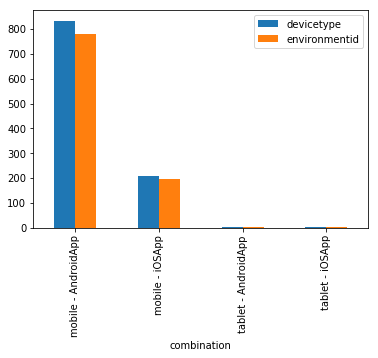

In [33]:
# If you would like to visualize in the jupyter notebook your plot then
%matplotlib inline
df_events.groupby('combination').agg(dic).plot(kind='bar')

> Later on we are going to learn how tune a graph!!

## **Exercise**

Which browsers are the most active - desktop, mobile or tablet?

Here *most active* means those that generate the highest number of events.


In [34]:
%%time

# Doing a simple query of the events in one hour
query = """
SELECT
  devicetype,
  count(devicetype) as nof_events,
  count(distinct environmentid) as nof_users
FROM
  {}_databox.yellow_pulse_simple_1d
GROUP BY 
  devicetype
"""
df = pd.read_sql(query.format(provider), conn)

CPU times: user 58.7 ms, sys: 5.62 ms, total: 64.3 ms
Wall time: 6.27 s


In [36]:
df

,devicetype,nof_events,nof_users
0,None,0,0
1,mobile,15200277,480279
2,desktop,1547187,64858
3,tablet,173867,6054


In [41]:
df_clean = df[-df['devicetype'].isna()].copy()
df_clean

,devicetype,nof_events,nof_users,volumeEvents,volumeUsers,eventsPeruser
1,mobile,15200277,480279,89.829086,87.134768,31.648848
2,desktop,1547187,64858,9.143412,11.766883,23.854991
3,tablet,173867,6054,1.027502,1.098349,28.719359


In [42]:
df_clean['volumeEvents'] = 100*df_clean['nof_events']/df_clean['nof_events'].sum()
df_clean['volumeUsers'] = 100*df_clean['nof_users']/df_clean['nof_users'].sum()
df_clean['eventsPeruser'] = df_clean['nof_events']/df_clean['nof_users']

In [44]:
df_clean.sort_values('volumeUsers',ascending =False)

,devicetype,nof_events,nof_users,volumeEvents,volumeUsers,eventsPeruser
1,mobile,15200277,480279,89.829086,87.134768,31.648848
2,desktop,1547187,64858,9.143412,11.766883,23.854991
3,tablet,173867,6054,1.027502,1.098349,28.719359


# Now 

![](pictures/your_turn.png)



# Run the following query

In [6]:
%%time
# Doing a simple query of the events in one hour
query = """
SELECT
  environmentid,
  providerproducttype,
  devicetype,
  isloggedin,
  type,
  objecttype,
  count(*) as nof_events
FROM
  {}_databox.yellow_pulse_simple_1d
GROUP BY
  environmentid,
  providerproducttype,
  devicetype,
  isloggedin,
  type,
  objecttype
"""
df = pd.read_sql(query.format(provider), conn)

CPU times: user 1min 41s, sys: 3.9 s, total: 1min 44s
Wall time: 11min 12s


In [8]:
df.head()

,environmentid,providerproducttype,devicetype,isloggedin,type,objecttype,nof_events,platform
0,sdrn:schibsted:environment:e53c8861-d45b-4831-...,n/a,mobile,False,View,Listing,10,Web - mobile
1,sdrn:schibsted:environment:8b733f0f-dc8d-4f14-...,n/a,mobile,False,View,Listing,73,Web - mobile
2,sdrn:schibsted:environment:07decafb-c1dc-454f-...,AndroidApp,mobile,True,View,Listing,87,Android
3,sdrn:schibsted:environment:0c3f508c-11f9-49bf-...,AndroidApp,mobile,True,View,ClassifiedAd,55,Android
4,sdrn:schibsted:environment:447cb6d0-434f-4856-...,AndroidApp,mobile,False,View,ClassifiedAd,79,Android


## ** Exercise 1 **:

Write a function (use *def*) in python to extract from the fields **devicetype** and **providerproducttype**  the platform associated to the event. The result of platform feature must be: *iOS*, *Android*, *Web* or *Undefined*

Apply this function to create a new column called **platform** and answer the following questions:

1.1 How many users are come from every platform? 

1.2 Out of all events what is the percentage of Listings and ClassifiedAds in every platform?


> Please write the results in the cardboard of the site that you are studying

In [ ]:
def getPlatform(row):
    if row.devicetype == "desktop":
        return "Web - desktop"
    elif "Android" in str(row.providerproducttype):
        return "Android"
    elif "iOS" in str(row.providerproducttype):
        return "iOS"
    elif row.devicetype == "mobile" and row.providerproducttype is None:
        return "Web - mobile"
    else:
        return "Undefined"

In [49]:
%%time
## df.apply is very slow (it's basically a "for loop"), we prefer vectorized approach, see times below

df["platform"] = df.apply(lambda row: getPlatform(row), axis=1)

CPU times: user 1min 12s, sys: 257 ms, total: 1min 12s
Wall time: 1min 13s


In [7]:
%%time
df["platform"] = "Undefined"
df.providerproducttype = df.providerproducttype.fillna("n/a")
df.loc[df.devicetype == "desktop", "platform"] = "Web - desktop"
df.loc[(df.devicetype == "mobile") & (df.providerproducttype == "n/a"), "platform"] = "Web - mobile"
df.loc[df.providerproducttype.str.contains("Android", na=False), "platform"] = "Android"
df.loc[df.providerproducttype.str.contains("iOS", na=False), "platform"] = "iOS"

CPU times: user 3.07 s, sys: 106 ms, total: 3.18 s
Wall time: 3.19 s


In [9]:
df.head(10)

,environmentid,providerproducttype,devicetype,isloggedin,type,objecttype,nof_events,platform
0,sdrn:schibsted:environment:e53c8861-d45b-4831-...,n/a,mobile,False,View,Listing,10,Web - mobile
1,sdrn:schibsted:environment:8b733f0f-dc8d-4f14-...,n/a,mobile,False,View,Listing,73,Web - mobile
2,sdrn:schibsted:environment:07decafb-c1dc-454f-...,AndroidApp,mobile,True,View,Listing,87,Android
3,sdrn:schibsted:environment:0c3f508c-11f9-49bf-...,AndroidApp,mobile,True,View,ClassifiedAd,55,Android
4,sdrn:schibsted:environment:447cb6d0-434f-4856-...,AndroidApp,mobile,False,View,ClassifiedAd,79,Android
5,sdrn:schibsted:environment:7cd21b2c-9e6f-4166-...,AndroidApp,mobile,True,View,ClassifiedAd,50,Android
6,sdrn:schibsted:environment:bf7628c1-4b37-4292-...,AndroidApp,mobile,False,View,Listing,13,Android
7,sdrn:schibsted:environment:4fcdbe75-c0dd-4395-...,n/a,mobile,False,View,Listing,40,Web - mobile
8,sdrn:schibsted:environment:f0160e7a-5d1c-4809-...,n/a,mobile,False,View,Page,3,Web - mobile
9,sdrn:schibsted:environment:65590ae1-a6ef-4bb5-...,iOSApp,mobile,False,View,Listing,66,iOS


> 1.1 How many users are come from every platform? 

In [54]:
agg_plat_dau = df.groupby('platform')['environmentid'].nunique()
agg_plat_dau

platform
Android          148229
Undefined          4977
Web - desktop     64858
Web - mobile     306996
iOS               40913
Name: environmentid, dtype: int64

In [55]:
agg_plat_dau.sum()

565973

In [57]:
100* agg_plat_dau/agg_plat_dau.sum()

platform
Android          26.190119
Undefined         0.879371
Web - desktop    11.459557
Web - mobile     54.242163
iOS               7.228790
Name: environmentid, dtype: float64

> 1.2 What is the percentage of Listings and ClassifiedAds in every platform?


In [73]:
total_events = df.groupby('platform').agg({'nof_events': 'sum'}).reset_index()
total_events

,platform,nof_events
0,Android,6771844
1,Undefined,134675
2,Web - desktop,1547187
3,Web - mobile,6636672
4,iOS,1853173


In [67]:
df_platforms = df[df["objecttype"].isin(["ClassifiedAd", "Listing"])].groupby(['platform','objecttype'])['nof_events'].sum()
df_platforms.head()

platform       objecttype  
Android        ClassifiedAd    2231978
               Listing         3971555
Undefined      ClassifiedAd      45721
               Listing           76656
Web - desktop  ClassifiedAd     537948
Name: nof_events, dtype: int64

In [70]:
lis_av_per_platform = df_platforms.reset_index().pivot_table(index='platform',columns='objecttype',values='nof_events')
lis_av_per_platform

objecttype,ClassifiedAd,Listing
platform,,
Android,2231978,3971555
Undefined,45721,76656
Web - desktop,537948,827753
Web - mobile,2194076,3878582
iOS,737869,535479


In [75]:
result = total_events.merge(lis_av_per_platform, on='platform', how='left')

In [76]:
result

,platform,nof_events,ClassifiedAd,Listing
0,Android,6771844,2231978,3971555
1,Undefined,134675,45721,76656
2,Web - desktop,1547187,537948,827753
3,Web - mobile,6636672,2194076,3878582
4,iOS,1853173,737869,535479


In [77]:
result['vol_Listings'] = 100 * result['Listing'] / result['nof_events']
result['vol_Adviews'] = 100 * result['ClassifiedAd'] / result['nof_events']

In [85]:
result

,platform,nof_events,ClassifiedAd,Listing,vol_Listings,vol_Adviews
0,Android,6771844,2231978,3971555,58.648058,32.959678
1,Undefined,134675,45721,76656,56.919250,33.949137
2,Web - desktop,1547187,537948,827753,53.500514,34.769423
3,Web - mobile,6636672,2194076,3878582,58.441671,33.059883
4,iOS,1853173,737869,535479,28.895252,39.816520


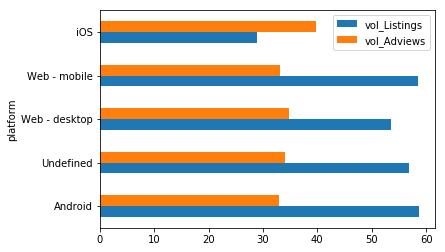

In [87]:
result.index = result.platform
result[['vol_Listings','vol_Adviews']].plot(kind='barh')

## **Exercise 2**:

There is a field called **isloggedin** which is refered events when the user is logged.

2.1 What's the percentage of browsers that are logged users?

> Please write the results in the cardboard of the site that you are studying

In [91]:
aux = df.groupby(['environmentid', 'isloggedin'], as_index=False)['nof_events'].sum()
table = aux.reset_index().pivot_table(index='environmentid',columns='isloggedin',values='nof_events').fillna(0)
table.head()

isloggedin,False,True
environmentid,,
sdrn:schibsted:environment:000024fa-0edb-4c2c-9790-e1a5ad503faa,381.0,0.0
sdrn:schibsted:environment:000038b8-9ae4-41d1-91fa-206f59601f87,17.0,0.0
sdrn:schibsted:environment:00004a61-1922-4781-983a-0c4465b9ce1d,16.0,0.0
sdrn:schibsted:environment:000050af-4577-4b59-a142-77974dba2bd3,108.0,0.0
sdrn:schibsted:environment:00007510-1fff-4cac-a897-4e0547eee9ad,0.0,30.0


In [92]:
table.columns

Index([False, True], dtype='object', name='isloggedin')

In [99]:
table = table.reset_index()

In [101]:
table.columns

Index(['environmentid', False, True], dtype='object', name='isloggedin')

In [102]:
table['log_user'] = table[True] > 0

In [105]:
table['log_user'].value_counts(normalize=True)

False    0.659623
True     0.340377
Name: log_user, dtype: float64

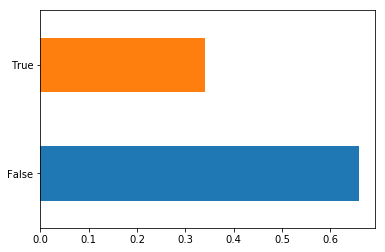

In [104]:
table['log_user'].value_counts(normalize=True).plot(kind='barh')

## **Exercise 3**:

If we define as:
    
**browser**: Active user with at least one Listing View or one Ad View in the session.
    
**buyer**: Active user who has *contacted* at least one Lister.

To *contact* means to do one of the following actions:
    
Call-->PhoneContact

Show-->PhoneContact

Send-->Message

SMS-->PhoneContact


**lister**: Active user who has tried to publish one ad. This is refering to Create-ClassifiedAd event.


3.1. Could you compute percentage of browsers, buyer and seller per platform?


In [13]:
browser_mask = (df["objecttype"] == "Listing") & (df["type"] == "View") | (df["objecttype"] == "ClassifiedAd") & (df["type"] == "View")
buyer_mask = df["type"].isin(["Call", "Show", "Send", "SMS"])
lister_mask = (df["objecttype"] == "ClassifiedAd") & (df["type"] == "Create")

df["isBrowser"] =  False
df["isBuyer"] =  False
df["isLister"] =  False

df.loc[browser_mask, "isBrowser"] = True
df.loc[buyer_mask, "isBuyer"] = True
df.loc[lister_mask, "isLister"] = True

In [14]:
table = df.groupby(["platform", 
                 "isBrowser",
                 "isBuyer",
                 "isLister"]).agg({'environmentid':'nunique'})

In [15]:
table

environmentid
platform      isBrowser isBuyer isLister               
Android       False     False   False             66222
                                True               5096
                        True    False             24668
              True      False   False            156604
Undefined     False     False   False              2500
                        True    False               354
              True      False   False              4077
Web - desktop False     False   False             80458
                        True    False              8806
              True      False   False            112284
Web - mobile  False     False   False            171454
                        True    False             41821
              True      False   False            300815
iOS           False     False   False             44079
                                True               1495
                        True    False              4616
              True      False   False             43254